## Strategy attempting to select earnings  winners based on their debt / ebitda

This strategy only trades during earnings periods, an earning period start when 2% of the SP500 stock have reported and ends when 98% of the SP500 has reported, other % rules have been tested and produced similar results.

During these earnings periods, the signal assess the last 50 days kurtosis of the stock debt/ebitda Time serie. 

This Time serie has previously been ranked  on a rolling basis for the last 500 days (only in earnings periods)

This means the signal at date t is the kurtosis of the metrics on the last 50  earning period  days.



In [1]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe
from pandas.tseries.offsets import BDay
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
market_data = pd.read_parquet('data/US/mkt_data.pq')
balance_sheet = pd.read_parquet('data/US/balance_sheets.pq')
GICS = pd.read_parquet('data/US/GICS.pq')
P = pd.read_parquet('data/US/universe_table.pq')
R = market_data['close'].unstack().reindex_like(P).pct_change()
market_data.head()

,,datetime,open,high,low,close,adj_close,volume,MktCap
Date,Ticker,,,,,,,,
2008-01-02,A,2008-01-02,36.6587,36.7886,36.1089,36.2888,23.4977,1858900,NaN
2008-01-03,A,2008-01-03,36.2888,36.3388,35.8589,35.9289,23.2647,1995302,NaN
2008-01-04,A,2008-01-04,35.5690,35.8389,34.7093,34.7593,22.5073,3533080,NaN
2008-01-07,A,2008-01-07,35.3291,35.8689,35.0392,35.3291,22.8763,3505732,NaN
2008-01-08,A,2008-01-08,35.3491,35.7390,35.1392,35.2791,22.8439,4063445,NaN


In [3]:
balance_sheet = pd.read_parquet('data/US/balance_sheets.pq')
balance_sheet['Date'] = pd.to_datetime(balance_sheet['filing_date'])
balance_sheet = balance_sheet.droplevel(0).set_index('Date',append=True)
balance_sheet = balance_sheet.reorder_levels(['Date','Ticker'])
balance_sheet = balance_sheet[~balance_sheet.index.duplicated(keep='first')]
balance_sheet.head()

,,date,filing_date,currency_symbol,totalAssets,intangibleAssets,earningAssets,otherCurrentAssets,totalLiab,totalStockholderEquity,deferredLongTermLiab,...,preferredStockRedeemable,capitalSurpluse,liabilitiesAndStockholdersEquity,cashAndShortTermInvestments,propertyPlantAndEquipmentGross,propertyPlantAndEquipmentNet,accumulatedDepreciation,netWorkingCapital,netInvestedCapital,commonStockSharesOutstanding
Date,Ticker,,,,,,,,,,,,,,,,,,,,,
1999-01-31,A,1999-01-31,1999-01-31,USD,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,462500000.00
1999-04-30,A,1999-04-30,1999-04-30,USD,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,461764706.00
1999-07-31,A,1999-07-31,1999-07-31,USD,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,450000000.00
1999-10-31,A,1999-10-31,1999-10-31,USD,5444000000.00,None,None,404000000.00,2062000000.00,3382000000.00,None,...,None,None,5444000000.00,None,1387000000.00,1387000000.00,None,None,None,440000000.00
2000-03-15,A,2000-01-31,2000-03-15,USD,7107000000.00,None,None,560000000.00,2621000000.00,4486000000.00,None,...,None,None,7107000000.00,1410000000.00,1408000000.00,1408000000.00,None,None,None,440000000.00


In [4]:
income_statement = pd.read_parquet('data/US/income_statement.pq')
income_statement['Date'] = pd.to_datetime(income_statement['filing_date'])
income_statement = income_statement.droplevel(0).set_index('Date',append=True)
income_statement = income_statement.reorder_levels(['Date','Ticker'])
income_statement = income_statement[~income_statement.index.duplicated(keep='first')]
income_statement.head()

,,date,filing_date,currency_symbol,researchDevelopment,effectOfAccountingCharges,incomeBeforeTax,minorityInterest,netIncome,sellingGeneralAdministrative,sellingAndMarketingExpenses,...,otherItems,incomeTaxExpense,totalRevenue,totalOperatingExpenses,costOfRevenue,totalOtherIncomeExpenseNet,discontinuedOperations,netIncomeFromContinuingOps,netIncomeApplicableToCommonShares,preferredStockAndOtherAdjustments
Date,Ticker,,,,,,,,,,,,,,,,,,,,,
1999-01-31,A,1999-01-31,1999-01-31,USD,None,None,None,None,74000000.00,None,None,...,None,None,1786000000.00,None,None,None,None,None,None,None
1999-04-30,A,1999-04-30,1999-04-30,USD,None,None,None,None,157000000.00,None,None,...,None,None,2010000000.00,None,None,None,None,None,None,None
1999-07-31,A,1999-07-31,1999-07-31,USD,None,None,None,None,135000000.00,None,None,...,None,None,2087000000.00,None,None,None,None,None,None,None
1999-10-31,A,1999-10-31,1999-10-31,USD,None,None,None,None,146000000.00,None,None,...,None,None,2448000000.00,None,None,None,None,None,None,None
2000-03-15,A,2000-01-31,2000-03-15,USD,290000000.00,0.00,202000000.00,0.00,131000000.00,625000000.00,None,...,0.00,71000000.00,2246000000.00,915000000.00,1160000000.00,31000000.00,0.00,0.00,88000000.00,None


In [5]:
earnings = pd.read_parquet('data/US/earnings.pq')
earnings['Date'] = pd.to_datetime(earnings['reportDate'])
earnings = earnings.droplevel(0).set_index('Date',append=True)
earnings = earnings.reorder_levels(['Date','Ticker'])
earnings = earnings[~earnings.index.duplicated(keep='first')]
earnings = earnings[earnings['epsActual'].notna()]
earnings['EarningsQuarter'] = pd.to_datetime(earnings['reportDate']).dt.to_period('Q')
earnings['IsReporting'] = 1

In [6]:
def business_days(start_date,end_date):
    dates_list = pd.date_range(start=start_date,end=end_date,freq='D')
    bd_list = [date for date in dates_list if date.weekday()< 5]
    return bd_list


def DATES_EARNINGS(data:pd.DataFrame,start:float,end:float,_days_before:int,_days_after:int):

    all_earnings =data['EarningsQuarter'].dropna().unique().tolist()
    dates_earnings = pd.DataFrame(index = all_earnings,columns = ['start_pre','end_pre','start','end','start_post','end_post'])

    for earning in all_earnings:

        sample = data[data['EarningsQuarter']==earning][['IsReporting']]
        
        sample['IsReporting_%'] = sample['IsReporting'].div(sample['IsReporting'].sum())
        df = pd.DataFrame(sample.groupby(level=0)['IsReporting_%'].sum())
        tmp = (df['IsReporting_%']>start ) & (df['IsReporting_%']<end )

        try :
            dates_earnings.loc[earning,'start'] = df[tmp].index[0]
            dates_earnings.loc[earning,'end'] = df[tmp].index[-1]
            dates_earnings.loc[earning,'start_pre'] = dates_earnings.loc[earning,'start'] + BDay(-1- _days_before)
            dates_earnings.loc[earning,'end_pre'] = dates_earnings.loc[earning,'start'] + BDay(-1)
            dates_earnings.loc[earning,'start_post'] = dates_earnings.loc[earning,'end'] + BDay(1)
            dates_earnings.loc[earning,'end_post'] = dates_earnings.loc[earning,'end'] + BDay(1+_days_after)
            
        except :
            ''
    dates_earnings = dates_earnings.dropna()
    dates_earnings['dates_pre'] =   dates_earnings.apply(lambda x: business_days(x['start_pre'],x['end_pre']),axis=1)
    dates_earnings['dates_earn'] =   dates_earnings.apply(lambda x: business_days(x['start'],x['end']),axis=1)
    dates_earnings['dates_post'] =   dates_earnings.apply(lambda x: business_days(x['start_post'],x['end_post']),axis=1)
    dates_earnings['dates_earn_cumul'] = dates_earnings['dates_earn'].cumsum()

    return dates_earnings.sort_index()


In [7]:
dates_earnings = DATES_EARNINGS(earnings,0.02,0.99,10,10)
dates_earnings_all = dates_earnings['dates_earn_cumul'].iloc[-1]
ebitda = income_statement['ebitda'].unstack().reindex_like(P).ffill().astype(float)
total_debt =balance_sheet['shortLongTermDebtTotal'].unstack().reindex_like(P).ffill().astype(float)
debt_to_ebitda = (total_debt/ebitda).stack()
dates_earnings
# start pre, end pre, start post, end post are pre earnings and post earnings season dates, they are not used to build the signal


,start_pre,end_pre,start,end,start_post,end_post,dates_pre,dates_earn,dates_post,dates_earn_cumul
1992Q2,1992-04-06 00:00:00,1992-04-20 00:00:00,1992-04-21 00:00:00,1992-06-30 00:00:00,1992-07-01 00:00:00,1992-07-15 00:00:00,"[1992-04-06 00:00:00, 1992-04-07 00:00:00, 199...","[1992-04-21 00:00:00, 1992-04-22 00:00:00, 199...","[1992-07-01 00:00:00, 1992-07-02 00:00:00, 199...","[2000-01-13 00:00:00, 2000-01-14 00:00:00, 200..."
1993Q1,1993-01-01 00:00:00,1993-01-15 00:00:00,1993-01-18 00:00:00,1993-03-31 00:00:00,1993-04-01 00:00:00,1993-04-15 00:00:00,"[1993-01-01 00:00:00, 1993-01-04 00:00:00, 199...","[1993-01-18 00:00:00, 1993-01-19 00:00:00, 199...","[1993-04-01 00:00:00, 1993-04-02 00:00:00, 199...","[2000-01-13 00:00:00, 2000-01-14 00:00:00, 200..."
1993Q2,1993-03-29 00:00:00,1993-04-12 00:00:00,1993-04-13 00:00:00,1993-06-30 00:00:00,1993-07-01 00:00:00,1993-07-15 00:00:00,"[1993-03-29 00:00:00, 1993-03-30 00:00:00, 199...","[1993-04-13 00:00:00, 1993-04-14 00:00:00, 199...","[1993-07-01 00:00:00, 1993-07-02 00:00:00, 199...","[2000-01-13 00:00:00, 2000-01-14 00:00:00, 200..."
1993Q3,1993-06-29 00:00:00,1993-07-13 00:00:00,1993-07-14 00:00:00,1993-09-30 00:00:00,1993-10-01 00:00:00,1993-10-15 00:00:00,"[1993-06-29 00:00:00, 1993-06-30 00:00:00, 199...","[1993-07-14 00:00:00, 1993-07-15 00:00:00, 199...","[1993-10-01 00:00:00, 1993-10-04 00:00:00, 199...","[2000-01-13 00:00:00, 2000-01-14 00:00:00, 200..."
1993Q4,1993-09-30 00:00:00,1993-10-14 00:00:00,1993-10-15 00:00:00,1993-12-31 00:00:00,1994-01-03 00:00:00,1994-01-17 00:00:00,"[1993-09-30 00:00:00, 1993-10-01 00:00:00, 199...","[1993-10-15 00:00:00, 1993-10-18 00:00:00, 199...","[1994-01-03 00:00:00, 1994-01-04 00:00:00, 199...","[2000-01-13 00:00:00, 2000-01-14 00:00:00, 200..."
...,...,...,...,...,...,...,...,...,...,...
2022Q3,2022-07-05 00:00:00,2022-07-19 00:00:00,2022-07-20 00:00:00,2022-08-09 00:00:00,2022-08-10 00:00:00,2022-08-24 00:00:00,"[2022-07-05 00:00:00, 2022-07-06 00:00:00, 202...","[2022-07-20 00:00:00, 2022-07-21 00:00:00, 202...","[2022-08-10 00:00:00, 2022-08-11 00:00:00, 202...","[2000-01-13 00:00:00, 2000-01-14 00:00:00, 200..."
2022Q4,2022-10-03 00:00:00,2022-10-17 00:00:00,2022-10-18 00:00:00,2022-11-08 00:00:00,2022-11-09 00:00:00,2022-11-23 00:00:00,"[2022-10-03 00:00:00, 2022-10-04 00:00:00, 202...","[2022-10-18 00:00:00, 2022-10-19 00:00:00, 202...","[2022-11-09 00:00:00, 2022-11-10 00:00:00, 202...","[2000-01-13 00:00:00, 2000-01-14 00:00:00, 200..."
2023Q1,2023-01-09 00:00:00,2023-01-23 00:00:00,2023-01-24 00:00:00,2023-03-02 00:00:00,2023-03-03 00:00:00,2023-03-17 00:00:00,"[2023-01-09 00:00:00, 2023-01-10 00:00:00, 202...","[2023-01-24 00:00:00, 2023-01-25 00:00:00, 202...","[2023-03-03 00:00:00, 2023-03-06 00:00:00, 202...","[2000-01-13 00:00:00, 2000-01-14 00:00:00, 200..."
2023Q2,2023-03-17 00:00:00,2023-03-31 00:00:00,2023-04-03 00:00:00,2023-06-26 00:00:00,2023-06-27 00:00:00,2023-07-11 00:00:00,"[2023-03-17 00:00:00, 2023-03-20 00:00:00, 202...","[2023-04-03 00:00:00, 2023-04-04 00:00:00, 202...","[2023-06-27 00:00:00, 2023-06-28 00:00:00, 202...","[2000-01-13 00:00:00, 2000-01-14 00:00:00, 200..."


In [8]:
data = debt_to_ebitda.unstack()
data = data[data.index.isin(dates_earnings_all)]
data = data[P].rank(axis=1,pct=True,ascending=True)
data = data.rolling(500,min_periods=100).rank(pct=True,ascending=True)

In [9]:
def kurtosis(close, length=None, offset=None, **kwargs):
    """Indicator: Kurtosis"""
    # Validate Arguments
    length = int(length) if length and length > 0 else 30
    min_periods = int(kwargs["min_periods"]) if "min_periods" in kwargs and kwargs["min_periods"] is not None else length
    offset = int(offset) if offset else 0

    if close is None: return

    # Calculate Result
    kurtosis = close.rolling(length, min_periods=min_periods).kurt()

    # Offset
    if offset != 0:
        kurtosis = kurtosis.shift(offset)

    # Handle fills
    if "fillna" in kwargs:
        kurtosis.fillna(kwargs["fillna"], inplace=True)
    if "fill_method" in kwargs:
        kurtosis.fillna(method=kwargs["fill_method"], inplace=True)
    return kurtosis

In [10]:
results ={}
for ticker in tqdm(data.columns.tolist()):
    df_ticker = data[ticker]
    try :
        metrics = kurtosis(data[ticker],length=50).fillna(0)
        results[ticker] = metrics

    except :
        print(ticker)
metrics = pd.concat(results,axis=1).reindex_like(P)

  0%|          | 0/674 [00:00<?, ?it/s]c:\Users\marti\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\window\rolling.py:655: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
100%|██████████| 674/674 [00:00<00:00, 2352.52it/s]


C:\Users\marti\AppData\Local\Temp\ipykernel_6056\1999238747.py:2: FutureWarning: Passing additional kwargs to Rolling.rank has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  signal = signal[P].rolling(10,min_periods=5).rank(axis=0,pct=True,ascending=True).clip(0.01,0.99)
C:\Users\marti\AppData\Local\Temp\ipykernel_6056\1999238747.py:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  signal = signal[P].groupby(GICS['gicind'],axis=1).apply(center)


Sharpe                        2.3
Average daily turnover (%)    0.1
Average Daily PNL (bp)        1.4
dtype: float64

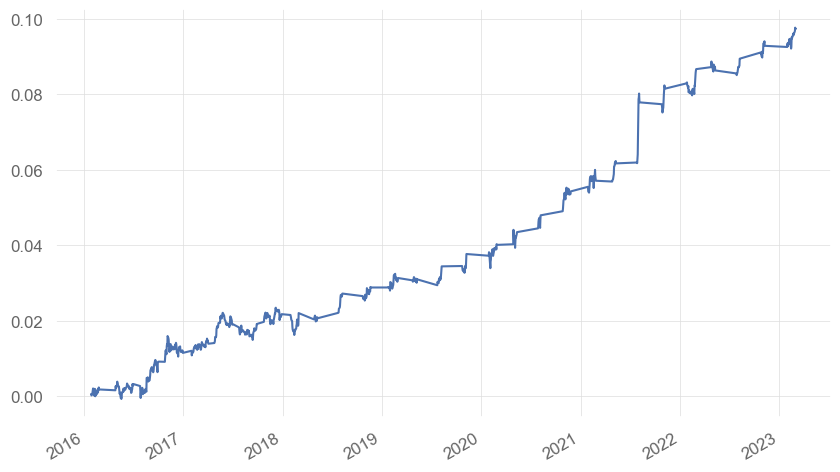

In [15]:
signal = metrics[P].reindex_like(P).rank(axis=1,pct=True,ascending=False).clip(0.01,0.99).apply(norm.ppf)
signal = signal[P].rolling(10,min_periods=5).rank(axis=0,pct=True,ascending=True).clip(0.01,0.99)
signal = signal[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)

signal[signal.abs()<0.25] = 0

signal = signal[P].groupby(GICS['gicind'],axis=1).apply(center)
signal = signal[P].div(signal[P].abs().sum(1),0)

PNL = (signal[P].shift()*R).sum(1).replace({0:np.nan}).dropna().loc['2016':]
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe':sr,'Average daily turnover (%)':turnover,'Average Daily PNL (bp)':PNL.mean()*1e4}).round(1)

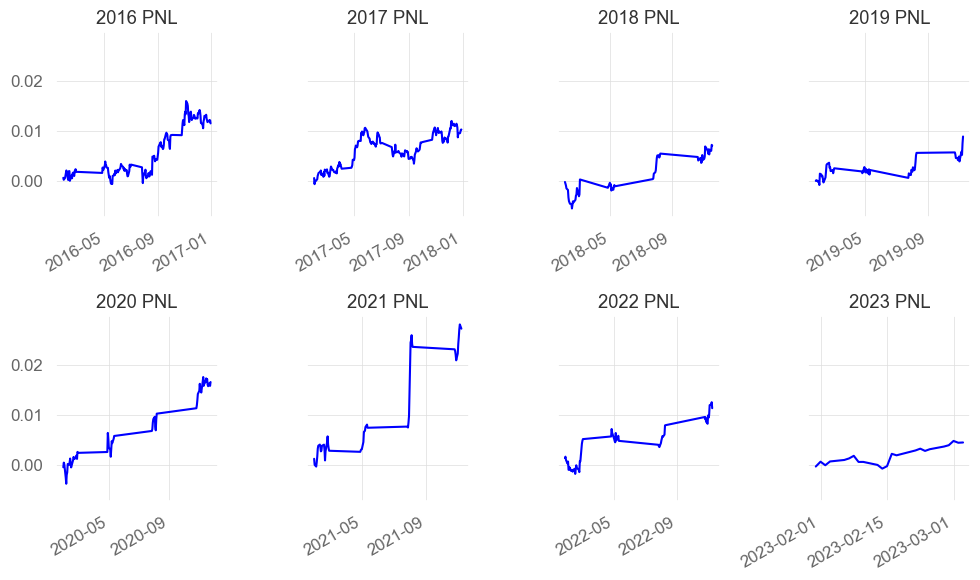

In [189]:
import matplotlib.dates as mdates
PNL_year = PNL.groupby(PNL.index.year).expanding().sum()
fig,axes = plt.subplots(nrows = 2, ncols = 4, sharey =True,sharex= False)

for i,year in enumerate([2016, 2017, 2018, 2019]):
    subset_pnl = PNL.loc[str(year)].cumsum()
    subset_pnl.plot(ax= axes[0,i], color = 'blue')
    axes[0,i].set_title(str(year) + ' PNL')
    axes[0,i].xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=4))

for i,year in enumerate([ 2020, 2021, 2022, 2023]):
    subset_pnl = PNL.loc[str(year)].cumsum()
    subset_pnl.plot(ax= axes[1,i], color = 'blue')
    axes[1,i].set_title(str(year) + ' PNL')
    axes[1,i].xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=4))

fig.tight_layout()
                        

<Axes: >

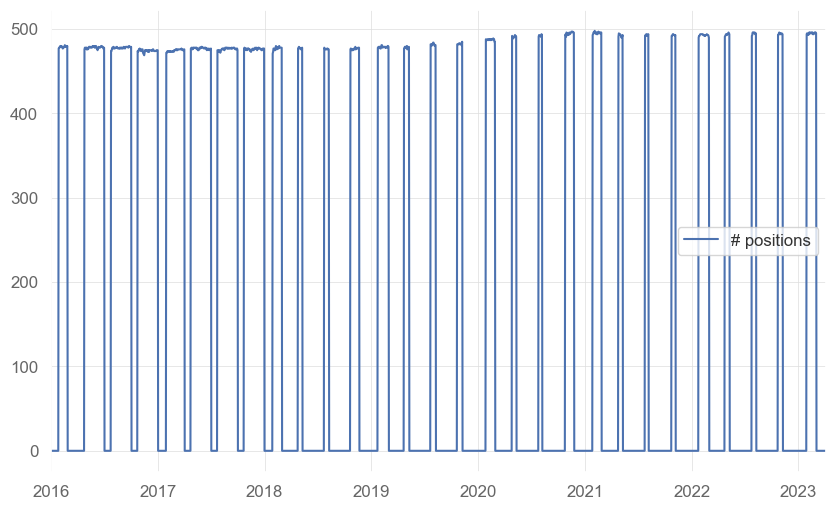

In [169]:
signal.count(1).plot(label ='# positions',legend=True)

<Axes: >

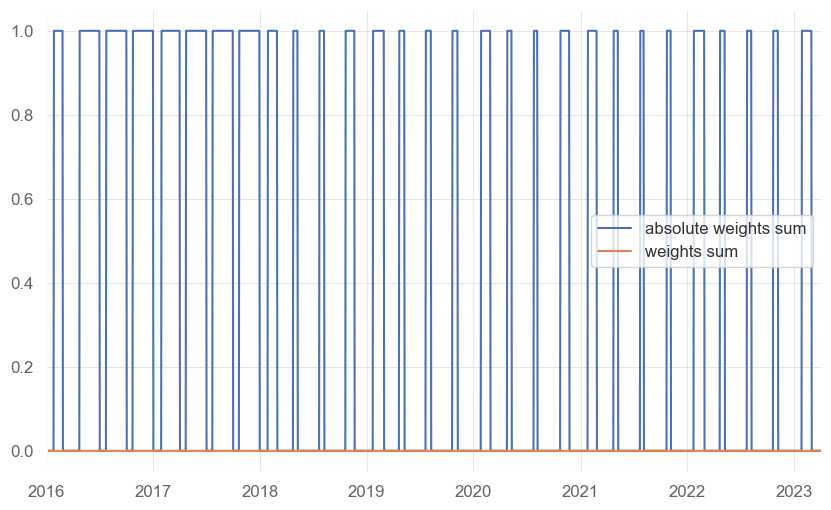

In [170]:
signal.abs().sum(1).plot(label = 'absolute weights sum',legend=True)
signal.sum(1).plot(label='weights sum',legend=True)